# Setup

In [3]:
import warnings

import matplotlib.patches as patches
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from mpl_toolkits import mplot3d
from mpl_toolkits.mplot3d.art3d import Poly3DCollection, Line3DCollection

from fairness.benchmark import NUM_TRIALS_DEFAULT

local_results_path: /Users/jb846j/.fairness
Available algorithms:
  SVM
  LR
  DecisionTree
  ZafarFairness
  Feldman-SVM
  Feldman-LR
  Feldman-DecisionTree


/Users/jb846j/miniconda3/envs/fairness-comparison/lib/python3.6/site-packages/matplotlib/__init__.py:1401: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [4]:
import matplotlib
matplotlib.__version__

'2.0.0'

In [5]:
# sns.set(rc={'axes.facecolor':'black'})
sns.set_style('darkgrid')
sns.set(font_scale=1.5)
cp = sns.color_palette()

In [6]:
FAIRNESS_DIR = '/Users/jb846j/.fairness/'
RESULTS_DIR = FAIRNESS_DIR + 'results/'
TEST_DATA_DIR = FAIRNESS_DIR + 'train_test_datasets/'

In [24]:
ALGOS = [
#          'Calders',
         'DecisionTree',
         'SVM',
#          'LR',
         'Feldman-DecisionTree',
         'Feldman-SVM',
#          'Feldman-LR',
#          'Kamishima',
#          'ZafarFairness',
#          'Random',
#          'Blandin-GaussianNB',
        ]

ALGO_LABELS = {v:ALGOS[i] for i,v in enumerate(ALGOS)}
ALGO_LABELS['DecisionTree'] = 'DT'
ALGO_LABELS['Feldman-DecisionTree'] = 'Feld-DT'
ALGO_LABELS['Feldman-SVM'] = 'Feld-SVM'
ALGO_LABELS['Feldman-LR'] = 'Feld-LR'
ALGO_LABELS['ZafarFairness'] = 'ZafarFair'
ALGO_LABELS['Feldman-DecisionTree_lambda=1.0'] = 'Feld-DT'
ALGO_LABELS['Feldman-SVM_lambda=1.0'] = 'Feld-SVM'

# Plotting Functions

In [8]:
def pareto_front(costs, get_max=True):
    """
    Find the pareto-efficient points
    
    Warning: does not gracefully handle null values.
    """
    costs = costs.copy()
    is_efficient = np.ones(costs.shape[0], dtype = bool)
    if not get_max:
        costs *= -1
    for i, c in enumerate(costs):
        is_efficient[i] = np.all(np.any(costs[:i]>c, axis=1)) and np.all(np.any(costs[i+1:]>c, axis=1))
    if not get_max:
        return costs[is_efficient] * -1
    else:
        return costs[is_efficient]

In [239]:
def min_ratio(x):
    """Returns the minimum of x or 1/x."""
    if x < 1:
        return x
    else:
        return 1/x

def plot_2d(file, x_metric, y_metric, z_metric=None, algos=ALGOS, metrics_to_convert=[],
            axes_to_invert=[], color_start_idx=0, fig=None, ax=None, qlow=.15, qhigh=.85):
    """
    Parameters
    ----------
    z_metric : str, optional
        Used to maintain consistent pareto frontiers. This is usefulfor when plotting
        multiple 2-D plots to represent a 3-D pareto frontier.
    """
    
    df = pd.read_csv(f'{RESULTS_DIR}{file}')
    
    if fig is None:
        fig, ax = plt.subplots(1, 1, figsize=(9, 8))

    for i, algo in enumerate(algos):
        
        if algo not in df['algorithm'].unique():
            warnings.warn(f'No data for {algo} algorithm')
            continue

        _df = df.query('algorithm == @algo')
        
        if (_df[x_metric].isna().all() or _df[y_metric].isna().all() or
            (z_metric is not None and df[z_metric].isna().all())):
            warnings.warn(f'No data for {algo} algorithm')
            continue
            
        # If unequal number of trials for each metric, need to take the union
        # or the pareto call doesn't work as expected (returns nans).
        if z_metric is None:
            _df = _df[(~_df[x_metric].isna()) & (~_df[y_metric].isna())]
        else:
            _df = _df[(~_df[x_metric].isna()) & (~_df[y_metric].isna()) & (~_df[z_metric].isna())]
        
        # Fairness metrics should be converted to "distance from one" since
        # they're currently centered around 1.
        if 'x' in metrics_to_convert:
#             _df[x_metric] = (_df[x_metric] - 1).abs()
            _df[x_metric] = _df[x_metric].apply(lambda x: min_ratio(x))
            
        if 'y' in metrics_to_convert:
#             _df[y_metric] = (_df[y_metric] - 1).abs()
            _df[y_metric] = _df[y_metric].apply(lambda x: min_ratio(x))
        if 'z' in metrics_to_convert:
#             _df[z_metric] = (_df[z_metric] - 1).abs()
            _df[z_metric] = _df[z_metric].apply(lambda x: min_ratio(x))

#         pareto_metrics = [x_metric, y_metric]
#         if z_metric is not None:
#             pareto_metrics.append(z_metric)
#         pf_top_right = pareto_front(_df[pareto_metrics].values)
#         pf_top_right_mean = np.mean(pf_top_right, axis=0)
        
#         pf_bottom_left = pareto_front(_df[pareto_metrics].values, get_max=False)
#         pf_bottom_left_mean = np.mean(pf_bottom_left, axis=0)
        
#         width = pf_top_right_mean[0] - pf_bottom_left_mean[0]
#         height = pf_top_right_mean[1] - pf_bottom_left_mean[1]
        
#         if width == 0 and height == 0:
#             warnings.warn('Pareto frontier is the same for max and min, indicating the metrics are perfectly correlated.')
        
#         points = np.array([[pf_bottom_left_mean[0],       pf_bottom_left_mean[1]],
#                            [pf_bottom_left_mean[0]+width, pf_bottom_left_mean[1]],
#                            [pf_bottom_left_mean[0],       pf_bottom_left_mean[1]+height],
#                            [pf_bottom_left_mean[0]+width, pf_bottom_left_mean[1]+height],
#                           ])
        
        
#         ax.scatter(x=points[:, 0], y=points[:, 1], alpha=.8, color=cp[i+color_start_idx])
#         ax.add_patch(patches.Rectangle(pf_bottom_left_mean, width, height, alpha=.5,
#                                        color=cp[i+color_start_idx], label=algo))

#         ax.scatter(_df[x_metric], _df[y_metric], alpha=.3, color=cp[i+color_start_idx],
#                    s=100)
            
        xlow = _df[x_metric].quantile(qlow)
        xhigh = _df[x_metric].quantile(qhigh)
        xerr = (xhigh-xlow)/2
        ylow = _df[y_metric].quantile(qlow)
        yhigh = _df[y_metric].quantile(qhigh)
        yerr = (yhigh-ylow)/2
        xmean = _df[x_metric].mean()
        ymean = _df[y_metric].mean()
        ax.scatter(xmean, ymean, alpha=.7, color=cp[i+color_start_idx],
                  s=450, label=ALGO_LABELS[algo])
        ax.errorbar(xmean, ymean, xerr=xerr, yerr=yerr, color=cp[i+color_start_idx],
                    alpha=.7, lw=3)

        
    ax.legend()
    ax.set_xlabel(x_metric)
    ax.set_ylabel(y_metric)
    
    if 'x' in axes_to_invert:
        ax.invert_xaxis()
    if 'y' in axes_to_invert:
        ax.invert_yaxis()
    
    return fig, ax

In [10]:
def plot_3d(file, x_metric, y_metric, z_metric, algos=ALGOS, metrics_to_convert=[],
            axes_to_invert=[], color_start_idx=0):
    df = pd.read_csv(f'{RESULTS_DIR}{file}')
    fig = plt.figure(figsize=(10, 9))
    ax = fig.add_subplot(111, projection='3d')

    
    for i, algo in enumerate(algos):
        
        if algo not in df['algorithm'].unique():
            warnings.warn(f'No data for {algo} algorithm')
            continue

        _df = df.query('algorithm == @algo')

        if _df[x_metric].isna().all() or _df[y_metric].isna().all() or _df[z_metric].isna().all():
            warnings.warn(f'No data for {algo} algorithm')
            continue
            
        # If unequal number of trials for each metric, need to take the union
        # or the pareto call doesn't work as expected (returns nans).
        _df = _df[(~_df[x_metric].isna()) & (~_df[y_metric].isna()) & (~_df[z_metric].isna())]
        
        # Fairness metrics should be converted to "distance from one" since
        # they're currently centered around 1.
        if 'x' in metrics_to_convert:
            _df[x_metric] = (_df[x_metric] - 1).abs()
        if 'y' in metrics_to_convert:
            _df[y_metric] = (_df[y_metric] - 1).abs()
        if 'z' in metrics_to_convert:
            _df[z_metric] = (_df[z_metric] - 1).abs()
        
        # Get the maximum pareto frontier
        # pftrb stands for pf_top_right_back. It's a collection of points.
        pftrb = pareto_front(_df[[x_metric, y_metric, z_metric]].values)
        # pftrbm is a single point since it's the mean of all pftrb.
        pftrbm = np.mean(pftrb, axis=0)
        
        # Get the minimum pareto frodntier
        # pfbl stands for pf_bottom_left_front. It's a collection of points.
        pfbl = pareto_front(_df[[x_metric, y_metric, z_metric]].values, get_max=False)
        # pfblfm is a single point since it's the mean of pfbl.
        pfblfm = np.mean(pfbl, axis=0)
        
        # Shorten name so that grid is easier to visualize
        b = pfblfm
        t = pftrbm
        
        w = t[0] - b[0]  # width
        l = t[1] - b[1]  # depth
        h = t[2] - b[2]  # height
        
        if w == 0 and l == 0 and h == 0:
            warnings.warn('Pareto frontier is the same for max and min, indicating the metrics are perfectly correlated.')

        a = pfblfm
        b = [a[0]+w, a[1]  , a[2]  ]
        c = [a[0]  , a[1]  , a[2]+h]
        d = [a[0]+w, a[1]  , a[2]+h]
        e = [a[0]  , a[1]+l, a[2]  ]
        f = [a[0]+w, a[1]+l, a[2]  ]
        g = [a[0]  , a[1]+l, a[2]+h]
        h = [a[0]+w, a[1]+l, a[2]+h]

        Z = np.array([a, b, f, e, c, d, h, g])
        
        ax.scatter3D(Z[:, 0], Z[:, 1], Z[:, 2], label=algo, 
                     c=cp[i+color_start_idx], s=25)
        verts = [[Z[0],Z[1],Z[2],Z[3]],
                 [Z[4],Z[5],Z[6],Z[7]],
                 [Z[0],Z[1],Z[5],Z[4]],
                 [Z[2],Z[3],Z[7],Z[6]],
                 [Z[1],Z[2],Z[6],Z[5]],
                 [Z[4],Z[7],Z[3],Z[0]]]
        
        coll = Poly3DCollection(verts,
                                linewidths=.25,
#                                 edgecolors='r',
                                alpha=.8)
        ax.add_collection3d(coll)
        # Need to set facecolor in separate call from Poly3DCollection,
        # otherwise the alpha gets overriden.
        coll.set_facecolor(cp[i+color_start_idx])
        
    ax.legend()
    ax.set_xlabel(x_metric)
    ax.set_ylabel(y_metric)
    ax.set_zlabel(z_metric)
    
    if 'x' in axes_to_invert:
        ax.invert_xaxis()
    if 'y' in axes_to_invert:
        ax.invert_yaxis()
    if 'z' in axes_to_invert:
        ax.invert_zaxis()
        
    ax.legend()
    plt.show()

# Analysis

### How well do existing fairness metrics evaluate fairness when a utility function is needed?

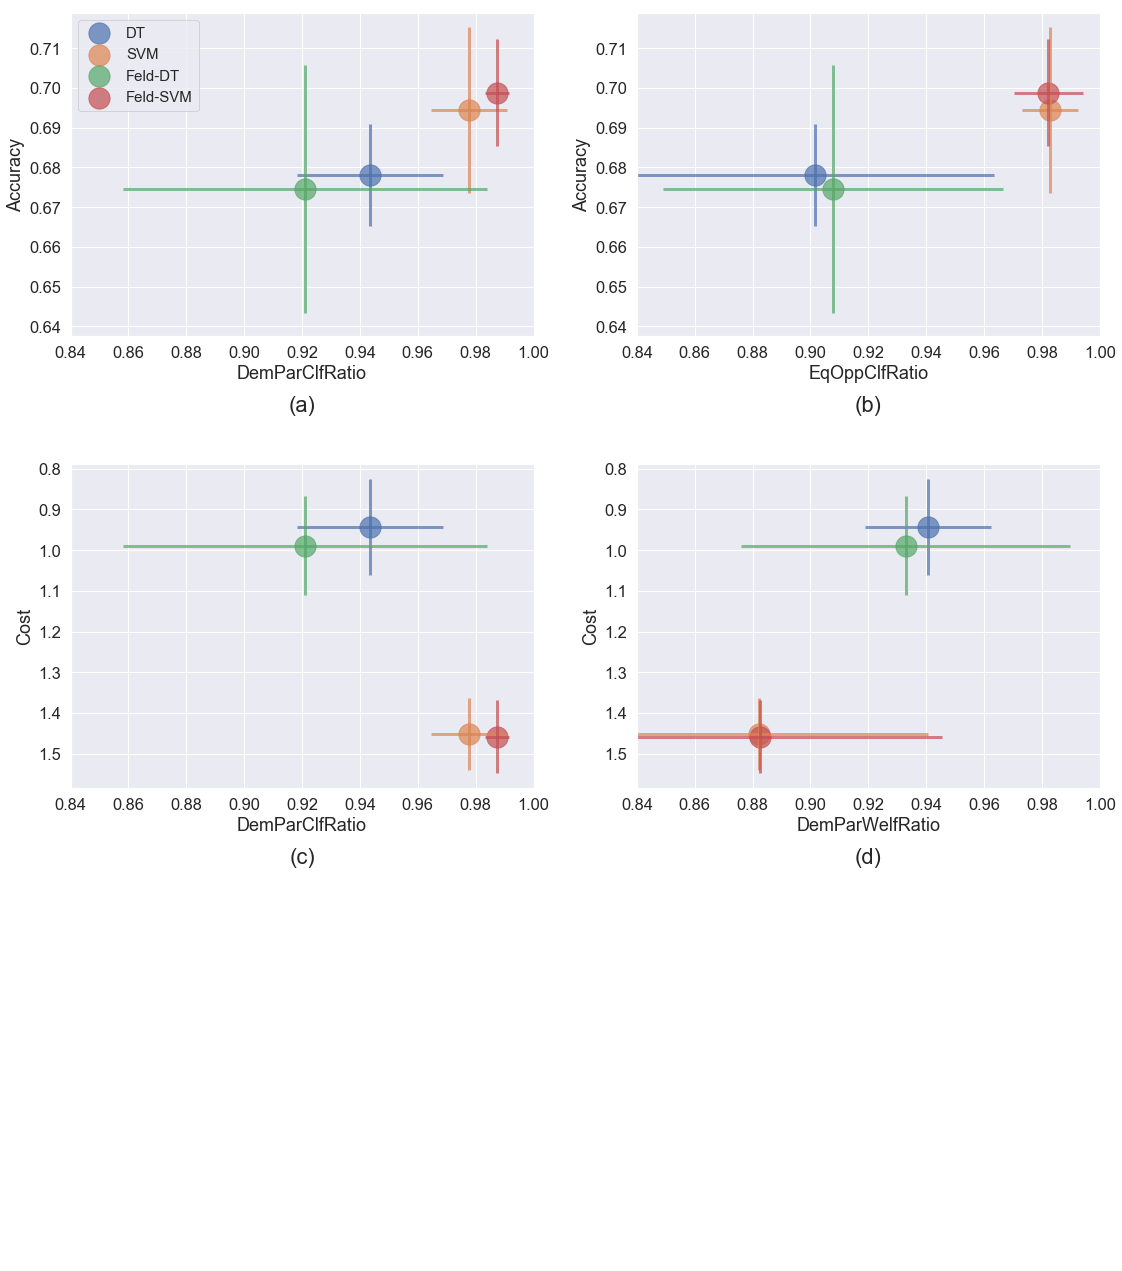

In [244]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 2, figsize=(16, 18))

#### ax1
plot_2d(file='german_sex_numerical-binsensitive.csv',
        x_metric='DIbinary',
        y_metric='accuracy',
        fig=fig,
        ax=ax1[0],
        metrics_to_convert=['x'],
        axes_to_invert=[],
       )

plot_2d(file='german_sex_numerical-binsensitive.csv',
        x_metric='EqOppo_tp_rate_ratio',
        y_metric='accuracy',
        fig=fig,
        ax=ax1[1],
        metrics_to_convert=['x'],
        axes_to_invert=[])


# ax3 Cost vs. DI
plot_2d(file='german_sex_numerical-binsensitive.csv',
        x_metric='DIbinary',
        y_metric='ExpCost_german_credit_payoffs',
        fig=fig,
        ax=ax2[0],
        metrics_to_convert=['x'],
        axes_to_invert=['y'])

plot_2d(file='german_sex_numerical-binsensitive.csv',
        x_metric='DemParWelf_german_credit_payoffs_tau=-1',
        y_metric='ExpCost_german_credit_payoffs',
        fig=fig,
        ax=ax2[1],
        metrics_to_convert=['x'],
        axes_to_invert=['y'])

#### ax3


# Fold
ax1[0].legend(fontsize='small', loc='upper left')
ax1[1].get_legend().remove()
ax2[0].get_legend().remove()
ax2[1].get_legend().remove()
ax1[0].set_xlabel('DemParClfRatio')
ax1[1].set_xlabel('EqOppClfRatio')
ax2[0].set_xlabel('DemParClfRatio')
ax2[1].set_xlabel('DemParWelfRatio')
ax1[0].set_ylabel('Accuracy')
ax1[1].set_ylabel('Accuracy')
ax2[0].set_ylabel('Cost')
ax2[1].set_ylabel('Cost')
ax2[0].set_title('(a)\n\n', fontsize=22)
ax2[1].set_title('(b)\n\n', fontsize=22)
ax3[0].set_title('(c)\n\n', fontsize=22)
ax3[1].set_title('(d)\n\n', fontsize=22)
ax3[0].axis('off')
ax3[1].axis('off')

ax1[0].set_xlim([.84, 1])
ax1[1].set_xlim([.84, 1])
ax2[0].set_xlim([.84, 1])
ax2[1].set_xlim([.84, 1])

# ax1[1].set_xlim([0, .3])
# ax1[1].set_xlim([.9, 0])

fig.tight_layout(h_pad=.75)
    
plt.show()

##### 2nd option

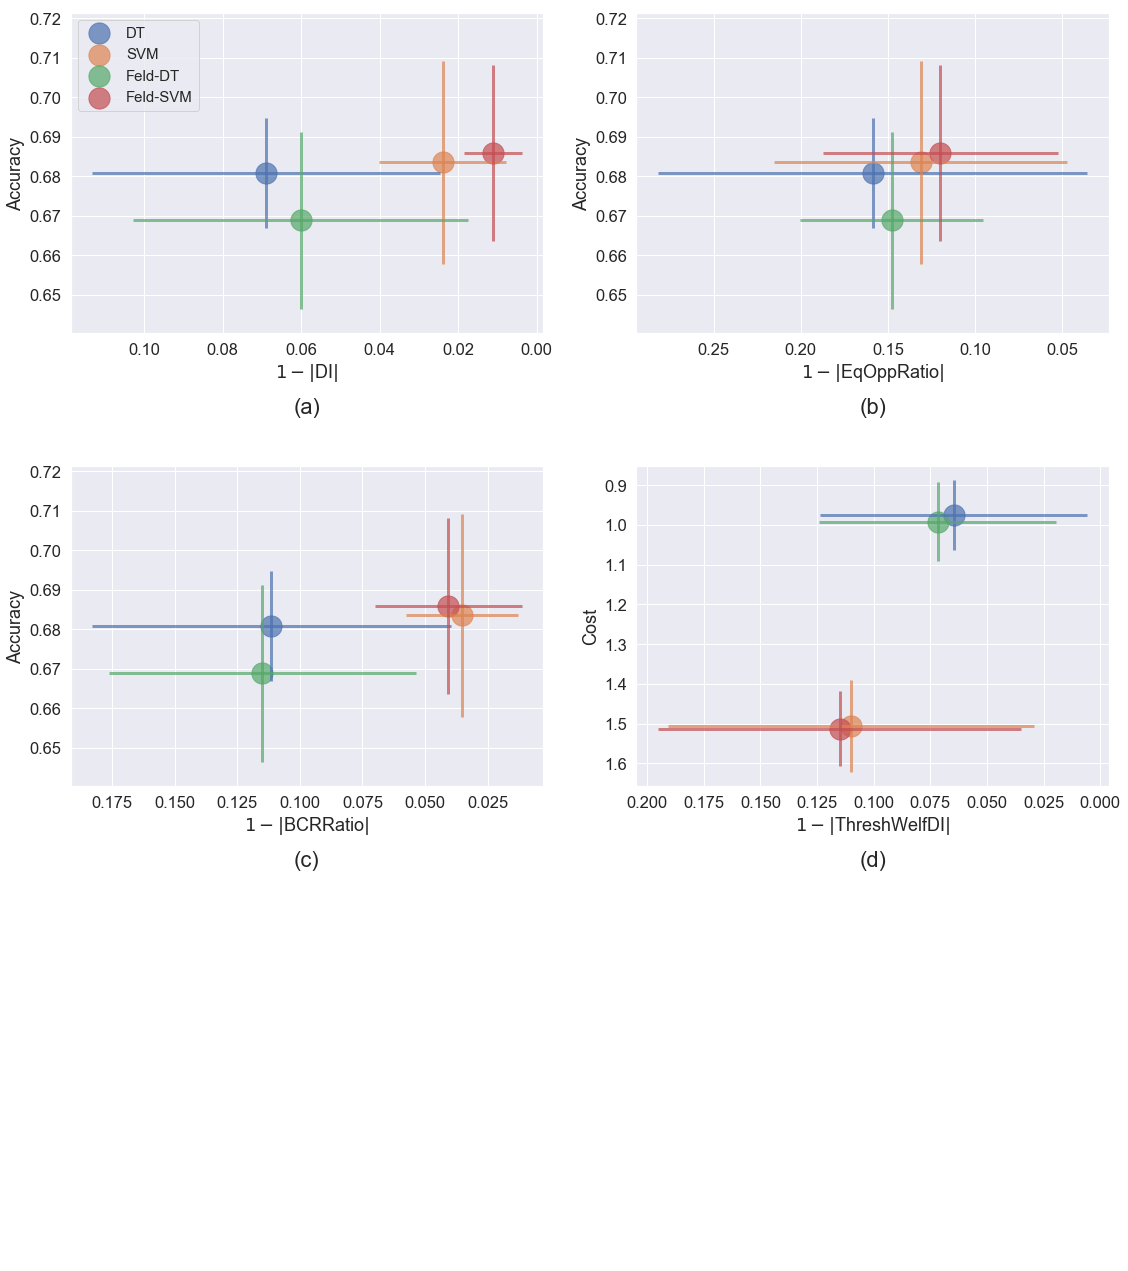

In [40]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 2, figsize=(16, 18))

#### ax1
plot_2d(file='german_sex_numerical-binsensitive.csv',
        x_metric='DIbinary',
        y_metric='accuracy',
        fig=fig,
        ax=ax1[0],
        metrics_to_convert=['x'],
        axes_to_invert=['x'],
       )

plot_2d(file='german_sex_numerical-binsensitive.csv',
        x_metric='EqOppo_tp_rate_ratio',
        y_metric='accuracy',
        fig=fig,
        ax=ax1[1],
        metrics_to_convert=['x'],
        axes_to_invert=['x'])

#### ax2

# BCRRatio
plot_2d(file='german_sex_numerical-binsensitive.csv',
        x_metric='0-BCR_over_1-BCR',
        y_metric='accuracy',
        fig=fig,
        ax=ax2[0],
        metrics_to_convert=['x'],
        axes_to_invert=['x'])

plot_2d(file='german_sex_numerical-binsensitive.csv',
        x_metric='DemParWelf_german_credit_payoffs_tau=-1',
        y_metric='ExpCost_german_credit_payoffs',
        fig=fig,
        ax=ax2[1],
        metrics_to_convert=['x'],
        axes_to_invert=['x', 'y'])

#### ax3
ax1[0].legend(fontsize='small', loc='upper left')
ax1[1].get_legend().remove()
ax2[0].get_legend().remove()
ax2[1].get_legend().remove()
ax1[0].set_xlabel('$1 - |$DI$|$')
ax1[1].set_xlabel('$1 - |$EqOppRatio$|$')
ax2[0].set_xlabel('$1 - |$BCRRatio$|$')
# ax2[0].set_xlabel('$1 - |$EqOppFPRatio$|$')
ax2[1].set_xlabel('$1 - |$ThreshWelfDI$|$')
ax1[0].set_ylabel('Accuracy')
ax1[1].set_ylabel('Accuracy')
ax2[0].set_ylabel('Accuracy')
ax2[1].set_ylabel('Cost')
ax2[0].set_title('(a)\n\n', fontsize=22)
ax2[1].set_title('(b)\n\n', fontsize=22)
ax3[0].set_title('(c)\n\n', fontsize=22)
ax3[1].set_title('(d)\n\n', fontsize=22)
ax3[0].axis('off')
ax3[1].axis('off')

fig.tight_layout(h_pad=.75)
    
plt.show()

### How well does DemParWelf perform as a fairness measure?

/Users/jb846j/miniconda3/envs/fairness-comparison/lib/python3.6/site-packages/ipykernel_launcher.py:19: UserWarning: No data for Calders algorithm
/Users/jb846j/miniconda3/envs/fairness-comparison/lib/python3.6/site-packages/ipykernel_launcher.py:19: UserWarning: No data for Kamishima algorithm


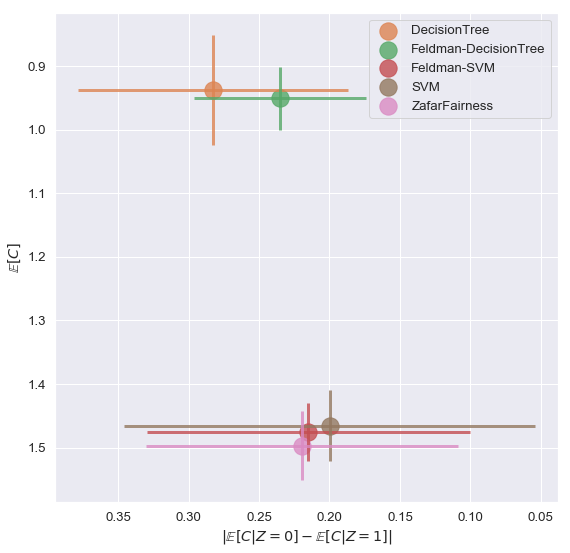

In [163]:
fig, ax = plt.subplots(1, 1, figsize=(9, 9))

plot_2d(file='german_sex_numerical-binsensitive.csv',
        x_metric='DemParWelf_german_credit_payoffs',
        y_metric='ExpCost_german_credit_payoffs',
        fig=fig,
        ax=ax,
        metrics_to_convert=['x'],
        axes_to_invert=['x', 'y'])

ax.set_ylabel('$\mathbb{E}[C]$')
ax.set_xlabel('$|\mathbb{E}[C|Z=0]-\mathbb{E}[C|Z=1]|$')
plt.show()

### Does it do any better when we have two different DemParWelf implementations?

/Users/jb846j/miniconda3/envs/fairness-comparison/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: No data for Kamishima algorithm
  # This is added back by InteractiveShellApp.init_path()


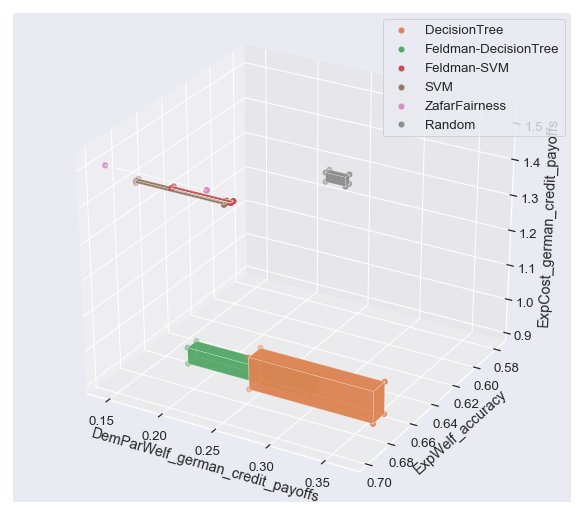

/Users/jb846j/miniconda3/envs/fairness-comparison/lib/python3.6/site-packages/ipykernel_launcher.py:19: UserWarning: No data for Kamishima algorithm
/Users/jb846j/miniconda3/envs/fairness-comparison/lib/python3.6/site-packages/ipykernel_launcher.py:58: UserWarning: Pareto frontier is the same for max and min, indicating the metrics are perfectly correlated.


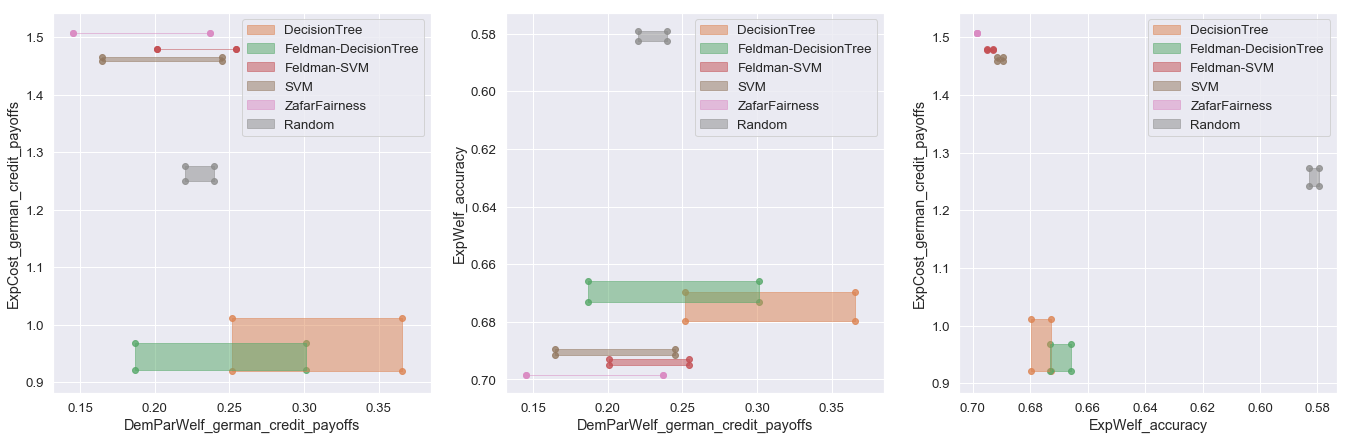

In [52]:
plot_3d(file='german_sex_numerical-binsensitive.csv',
        x_metric='DemParWelf_german_credit_payoffs',
        y_metric='ExpWelf_accuracy',
        z_metric='ExpCost_german_credit_payoffs',
        metrics_to_convert=['x'],
        axes_to_invert=['y'])

fig, ax = plt.subplots(1, 3, figsize=(23, 7))

plot_2d(file='german_sex_numerical-binsensitive.csv',
        x_metric='DemParWelf_german_credit_payoffs',
        y_metric='ExpCost_german_credit_payoffs',
        z_metric='ExpWelf_accuracy',
        fig=fig,
        ax=ax[0],
        metrics_to_convert=['x'],
        axes_to_invert=[])

plot_2d(file='german_sex_numerical-binsensitive.csv',
        x_metric='DemParWelf_german_credit_payoffs',
        y_metric='ExpWelf_accuracy',
        z_metric='ExpCost_german_credit_payoffs',
        fig=fig,
        ax=ax[1],
        metrics_to_convert=['x'],
        axes_to_invert=['y'])

plot_2d(file='german_sex_numerical-binsensitive.csv',
        x_metric='ExpWelf_accuracy',
        y_metric='ExpCost_german_credit_payoffs',
        z_metric='DemParWelf_german_credit_payoffs',
        fig=fig,
        ax=ax[2],
        metrics_to_convert=[],
        axes_to_invert=['x'])

plt.show()

# EDA



DecisionTree

	Female count = 1055
	Male   count = 2285

	Female Positive Rate: 0.639
	Male Positive Rate: 0.732


	Female Positive Prediction Rate: 0.666
	Male Positive Prediction Rate: 0.703

	 Female
		 Just Rejection:   0.172,  count: 181
		 Unjust Approval:  0.190,  count: 200
		 Unjust Rejection: 0.162,  count: 171
		 Just Approval:    0.477,  count: 503
	 Male
		 Just Rejection:   0.128,  count: 293
		 Unjust Approval:  0.140,  count: 319
		 Unjust Rejection: 0.168,  count: 385
		 Just Approval:    0.564,  count: 1288
	 Difference
		 Just Rejection:   0.043
		 Unjust Approval:  0.050
		 Unjust Rejection: -0.006
		 Just Approval:    -0.087

	ExpWelfDI_5:    0.281
	ThreshWelfD_5I: 0.058


,cost_5
sex,
0,-1.109953
1,-0.866521



	ExpWelfDI_2:    0.354
	ThreshWelfD_2I: 0.058


SVM

	Female count = 1055
	Male   count = 2285

	Female Positive Rate: 0.639
	Male Positive Rate: 0.732


	Female Positive Prediction Rate: 0.958
	Male Positive Prediction Rate: 0.975

	 Female
		 Just Rejection:   0.014,  count: 15
		 Unjust Approval:  0.347,  count: 366
		 Unjust Rejection: 0.027,  count: 29
		 Just Approval:    0.611,  count: 645
	 Male
		 Just Rejection:   0.009,  count: 21
		 Unjust Approval:  0.259,  count: 591
		 Unjust Rejection: 0.015,  count: 35
		 Just Approval:    0.717,  count: 1638
	 Difference
		 Just Rejection:   0.005
		 Unjust Approval:  0.088
		 Unjust Rejection: 0.012
		 Just Approval:    -0.105

	ExpWelfDI_5:    0.347
	ThreshWelfD_5I: 0.119


,cost_5
sex,
0,-1.762085
1,-1.308534



	ExpWelfDI_2:    0.342
	ThreshWelfD_2I: 0.119


Feldman-DecisionTree_lambda=1.0

	Female count = 1055
	Male   count = 2285

	Female Positive Rate: 0.639
	Male Positive Rate: 0.732


	Female Positive Prediction Rate: 0.708
	Male Positive Prediction Rate: 0.709

	 Female
		 Just Rejection:   0.156,  count: 165
		 Unjust Approval:  0.205,  count: 216
		 Unjust Rejection: 0.136,  count: 143
		 Just Approval:    0.503,  count: 531
	 Male
		 Just Rejection:   0.120,  count: 274
		 Unjust Approval:  0.148,  count: 338
		 Unjust Rejection: 0.171,  count: 390
		 Just Approval:    0.561,  count: 1283
	 Difference
		 Just Rejection:   0.036
		 Unjust Approval:  0.057
		 Unjust Rejection: -0.035
		 Just Approval:    -0.058

	ExpWelfDI_5:    0.273
	ThreshWelfD_5I: 0.067


,cost_5
sex,
0,-1.159242
1,-0.910284



	ExpWelfDI_2:    0.379
	ThreshWelfD_2I: 0.067


Feldman-SVM_lambda=1.0

	Female count = 1055
	Male   count = 2285

	Female Positive Rate: 0.639
	Male Positive Rate: 0.732


	Female Positive Prediction Rate: 0.973
	Male Positive Prediction Rate: 0.983

	 Female
		 Just Rejection:   0.014,  count: 15
		 Unjust Approval:  0.347,  count: 366
		 Unjust Rejection: 0.012,  count: 13
		 Just Approval:    0.627,  count: 661
	 Male
		 Just Rejection:   0.005,  count: 12
		 Unjust Approval:  0.263,  count: 600
		 Unjust Rejection: 0.012,  count: 27
		 Just Approval:    0.720,  count: 1646
	 Difference
		 Just Rejection:   0.009
		 Unjust Approval:  0.084
		 Unjust Rejection: 0.001
		 Just Approval:    -0.094

	ExpWelfDI_5:    0.319
	ThreshWelfD_5I: 0.114


,cost_5
sex,
0,-1.746919
1,-1.324726



	ExpWelfDI_2:    0.321
	ThreshWelfD_2I: 0.114


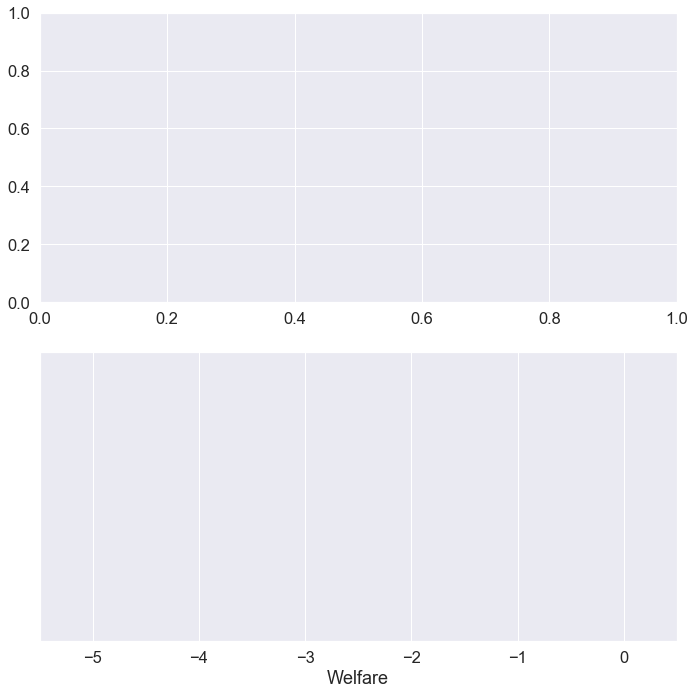

In [212]:
prefix = 'german_sex_numerical-binsensitive_'
algorithms = [
              'DecisionTree',
              'SVM',
#               'LR',
              'Feldman-DecisionTree_lambda=1.0',
              'Feldman-SVM_lambda=1.0',
#               'Feldman-LR_lambda=1.0',
#               'ZafarFairness_c=0.001',
              ]


def cost(y, yh, fp_cost=-5):
    if yh == y:
        return 0
    if yh == 2 and y == 1:
        return -1
    if yh == 1 and y == 2:
        return fp_cost
    else:
        print(y, yh)
        raise Exception('should not get here')
        

def expwelfdi(fcost, mcost):
    return np.abs(1 - fcost.mean() / mcost.mean())


def threshwelfdi(fcost, mcost, tau):
    return np.abs(1 - (fcost >= tau).astype(float).mean()/(mcost >= tau).astype(float).mean())


fig, axes = plt.subplots(2, 1, figsize=(10, 10))
# idx_to_ax = {0: axes[0][0],
#              1: axes[0][1],
#              2: axes[1][0],
#              3: axes[1][1],
#             }
    
for j, algorithm in enumerate(algorithms):
#     ax = idx_to_ax[j]
    ax2 = axes[0]
    ax = axes[1]
    print('\n\n'+algorithm)
    _prefix = prefix + algorithm
    _df = pd.read_csv(TEST_DATA_DIR + _prefix + '_0_test.csv')
    _df['run_id'] = 0

    for i in range(1, NUM_TRIALS_DEFAULT):
        _df_i = pd.read_csv(TEST_DATA_DIR+f'{_prefix}_{i}_test.csv')
        _df_i['run_id'] = i
        _df = pd.concat([_df, _df_i])
        
        # Debugging
#         _df_i['cost'] = _df_i.apply(lambda row: cost(row['credit'], row['preds']), axis=1)
#         f = _df_i.query('sex == 0')
#         m = _df_i.query('sex == 1')
#         ewdi = expwelfdi(f['cost'], m['cost'])
#         twdi = threshwelfdi(f['cost'], m['cost'], tau=-1)
#         acc = (_df_i['credit'] == _df_i['preds']).astype(float).mean()
#         pred_mean = _df_i['preds'].mean()
#         print(f'\n\tExpWelfDI:  {ewdi:.3f}')
#         print(f'\tThreshWelfDI: {twdi:.3f}')
#         print(f'\tAccuracy:     {acc: .3f}')
#         print(f"run_id={i}, test['credit'].sum()={_df_i['credit'].sum()}")
#         print(f"pred_mean={pred_mean:.3f}")
    
    _df['cost_5'] = _df.apply(lambda row: cost(row['credit'], row['preds'], fp_cost=-5), axis=1)
    _df['cost_2'] = _df.apply(lambda row: cost(row['credit'], row['preds'], fp_cost=-125), axis=1)

    f = _df.query('sex == 0')
    m = _df.query('sex == 1')
    
    print(f'\n\tFemale count = {len(f)}')
    print(f'\tMale   count = {len(m)}')
    
    print(f'\n\tFemale Positive Rate: {(f["credit"] == 1).mean():.3f}')
    print(f'\tMale Positive Rate: {(m["credit"] == 1).mean():.3f}\n')
    
    print(f'\n\tFemale Positive Prediction Rate: {(f["preds"] == 1).mean():.3f}')
    print(f'\tMale Positive Prediction Rate: {(m["preds"] == 1).mean():.3f}\n')

    tp_f = len(f.query("credit == 1 and preds == 1")) / len(f)
    tn_f = len(f.query("credit == 2 and preds == 2")) / len(f)
    fp_f = len(f.query("credit == 2 and preds == 1")) / len(f)
    fn_f = len(f.query("credit == 1 and preds == 2")) / len(f)
    print(f'\t Female')
    print(f'\t\t Just Rejection:  {tn_f: .3f},  count: {tn_f*len(f):.0f}')
    print(f'\t\t Unjust Approval:  {fp_f:.3f},  count: {fp_f*len(f):.0f}')
    print(f'\t\t Unjust Rejection: {fn_f:.3f},  count: {fn_f*len(f):.0f}')
    print(f'\t\t Just Approval:    {tp_f:.3f},  count: {tp_f*len(f):.0f}')
    
    tp_m = len(m.query("credit == 1 and preds == 1")) / len(m)
    tn_m = len(m.query("credit == 2 and preds == 2")) / len(m)
    fp_m = len(m.query("credit == 2 and preds == 1")) / len(m)
    fn_m = len(m.query("credit == 1 and preds == 2")) / len(m)
    print(f'\t Male')
    print(f'\t\t Just Rejection:  {tn_m: .3f},  count: {tn_m*len(m):.0f}')
    print(f'\t\t Unjust Approval:  {fp_m:.3f},  count: {fp_m*len(m):.0f}')
    print(f'\t\t Unjust Rejection: {fn_m:.3f},  count: {fn_m*len(m):.0f}')
    print(f'\t\t Just Approval:    {tp_m:.3f},  count: {tp_m*len(m):.0f}')
    
    tp_d = tp_f - tp_m
    tn_d = tn_f - tn_m
    fp_d = fp_f - fp_m
    fn_d = fn_f - fn_m
    print(f'\t Difference')
    print(f'\t\t Just Rejection:  {tn_d: .3f}')
    print(f'\t\t Unjust Approval:  {fp_d:.3f}')
    print(f'\t\t Unjust Rejection: {fn_d:.3f}')
    print(f'\t\t Just Approval:    {tp_d:.3f}')
                  
    ewdi_5 = expwelfdi(f['cost_5'], m['cost_5'])
    twdi_5 = threshwelfdi(f['cost_5'], m['cost_5'], tau=-1)
    print(f'\n\tExpWelfDI_5:    {ewdi_5:.3f}')
    print(f'\tThreshWelfD_5I: {twdi_5:.3f}')
    display(_df.groupby('sex')[['cost_5']].mean())
    
    ewdi_2 = expwelfdi(f['cost_2'], m['cost_2'])
    twdi_2 = threshwelfdi(f['cost_2'], m['cost_2'], tau=-1)
    print(f'\n\tExpWelfDI_2:    {ewdi_2:.3f}')
    print(f'\tThreshWelfD_2I: {twdi_2:.3f}')
#     display(_df.groupby('sex')[['cost_2']].mean())


    f_cost_pcts = f.groupby('cost_5')['credit'].count() / len(f)
    m_cost_pcts = m.groupby('cost_5')['credit'].count() / len(m)
    diff_cost_pcts = np.abs(f_cost_pcts - m_cost_pcts)
    ratio_cost_pcts = f_cost_pcts / m_cost_pcts

#     ax.set_title(ALGO_LABELS[algorithm])
#     ax.set_title(ALGO_LABELS[algorithm])
#     ax.hist(f['cost_5'],label='Female', alpha=.5, normed=True)
#     ax.hist(m['cost_5'],label='Male', alpha=.5, normed=True)

    
#     ax2.bar(left=diff_cost_pcts.index+(-.25 + j*.15),
#            height=ratio_cost_pcts.values - 1,
#            width=.15,
#            color=cp[j],
#            alpha=.7,
#            label=ALGO_LABELS[algorithm])
    
#     ax.bar(left=diff_cost_pcts.index+(-.25 + j*.15),
#            height=diff_cost_pcts.values,
#            width=.15,
#            color=cp[j],
#            alpha=.7,
#            label=ALGO_LABELS[algorithm])
#     sns.kdeplot(x=diff_cost_pcts.index, y=diff_cost_pcts.values, ax=ax)
#     sns.displot(f['cost_5'], ax=ax)
    ax.set_xlabel('Welfare')
#     ax.set_ylabel('Female Density - Male Density (absolute value)')
#     ax.set_ylim([-.1, .1])
    ax.legend()
    
    ax.set_xlim([-5.5, 0.5])
    ax.set_yticks([])

fig.tight_layout()    
plt.show()

In [72]:
plt.rcParams['hatch.color'] = 'white'

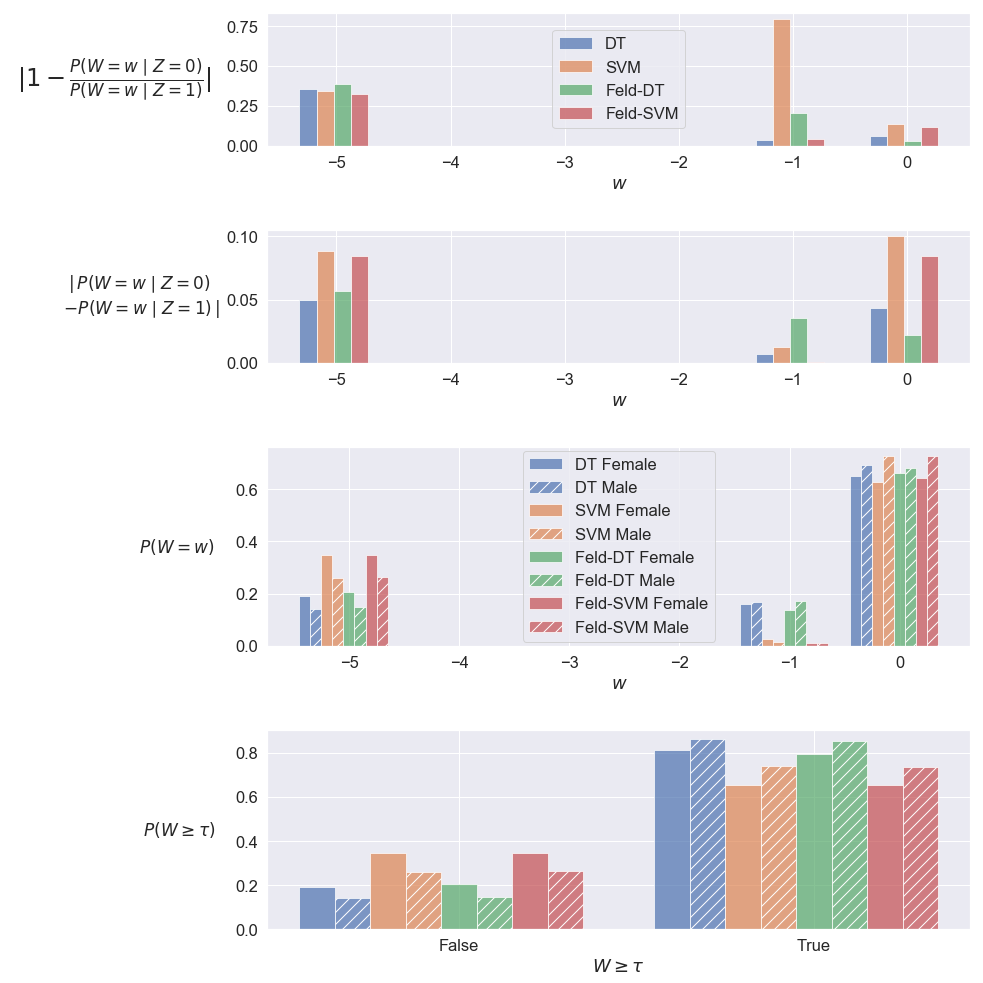

In [209]:
fig, axes = plt.subplots(4, 1, figsize=(14, 14), gridspec_kw={'height_ratios': [1, 1, 1.5, 1.5]})
    
for j, algorithm in enumerate(algorithms):
    ax1 = axes[0]
    ax2 = axes[1]
    ax3 = axes[2]
    ax4 = axes[3]
    
    _prefix = prefix + algorithm
    _df = pd.read_csv(TEST_DATA_DIR + _prefix + '_0_test.csv')
    _df['run_id'] = 0

    for i in range(1, NUM_TRIALS_DEFAULT):
        _df_i = pd.read_csv(TEST_DATA_DIR+f'{_prefix}_{i}_test.csv')
        _df_i['run_id'] = i
        _df = pd.concat([_df, _df_i])
    
    _df['cost_5'] = _df.apply(lambda row: cost(row['credit'], row['preds'], fp_cost=-5), axis=1)
    _df['cost_2'] = _df.apply(lambda row: cost(row['credit'], row['preds'], fp_cost=-125), axis=1)
    _df['above_tau'] = (_df['cost_5'] >= -1).astype(int)

    f = _df.query('sex == 0')
    m = _df.query('sex == 1')

    f_cost_pcts = f.groupby('cost_5')['credit'].count() / len(f)
    m_cost_pcts = m.groupby('cost_5')['credit'].count() / len(m)
    
    f_tau_pcts = f.groupby('above_tau')['credit'].count() / len(f)
    m_tau_pcts = m.groupby('above_tau')['credit'].count() / len(m)

    
    ratio_cost_pcts = np.abs(1 - (f_cost_pcts / m_cost_pcts))
    ax1.bar(left=ratio_cost_pcts.index+(-.25 + j*.15),
       height=ratio_cost_pcts.values,
       width=.15,
       color=cp[j],
       alpha=.7,
       label=ALGO_LABELS[algorithm])
    
    
    diff_cost_pcts = np.abs(f_cost_pcts - m_cost_pcts)
    ax2.bar(left=diff_cost_pcts.index+(-.25 + j*.15),
       height=diff_cost_pcts.values,
       width=.15,
       color=cp[j],
       alpha=.7,
       label=ALGO_LABELS[algorithm])
    
    w = .2
    ax3.bar(left=f_cost_pcts.index+(-1.5*w + j*w - w/2),
           height=f_cost_pcts.values,
           width=w/2,
           color=cp[j],
           alpha=.7,
           label=ALGO_LABELS[algorithm] + ' Female')
    
    ax3.bar(left=m_cost_pcts.index+(-1.5*w + j*w),
           height=m_cost_pcts.values,
           width=w/2,
           color=cp[j],
           alpha=.7,
           label=ALGO_LABELS[algorithm] + ' Male',
           hatch='//',
          )
    
    ax4.bar(left=f_tau_pcts.index+(-1.5*w + j*w - w/2),
           height=f_tau_pcts.values,
           width=w/2,
           color=cp[j],
           alpha=.7,
           label=ALGO_LABELS[algorithm] + ' Female')
    
    ax4.bar(left=m_tau_pcts.index+(-1.5*w + j*w),
           height=m_tau_pcts.values,
           width=w/2,
           color=cp[j],
           alpha=.7,
           label=ALGO_LABELS[algorithm] + ' Male',
           hatch='//',
          )    

ax1.set_ylabel('$             |1-\\frac{P(W=w\mid Z=0)}{P(W=w\mid Z=1)}|$  ',
              rotation=0, fontsize=24, ha='right', va='center')
ax1.set_xlabel('$w$')
ax1.legend(loc='center')
    
ax2.set_ylabel('             $|\,P(W=w\mid Z=0)$   \n $-P(W=w\mid Z=1)\,|$ ',
              rotation=0, fontsize=17, ha='right', va='center')
ax2.set_xlabel('$w$')
# ax2.set_title('\n')
# ax2.legend(loc='center')

ax3.set_xlabel('$w$')
ax3.set_ylabel('             $P(W=w)$    ',
              rotation=0, fontsize=17, ha='right', va='center')
ax3.legend(loc='center')

ax4.set_xlabel('$W\geq\\tau$')
ax4.set_ylabel('            $P(W\geq\\tau)$    ',
              rotation=0, fontsize=17, ha='right', va='center')
# ax4.legend(loc='center')
ax4.set_xticks([0, 1])
ax4.set_xticklabels(['False', 'True'])

# ax2 = axes[2]
# ax2.set_title('(b)\n')
# ax2.axis('off')
# ax2.axis('off')

fig.tight_layout(h_pad=1.75)
    
plt.show()

# Scratch

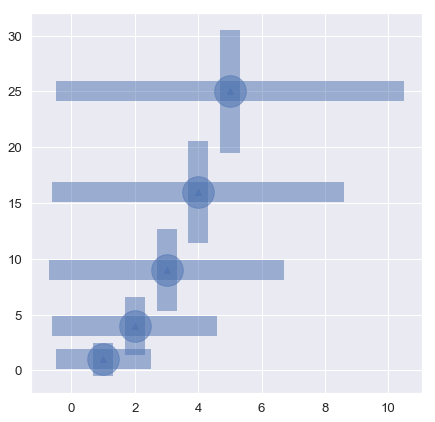

In [69]:
x = np.array([1, 2, 3, 4, 5])
y = np.power(x, 2) # Effectively y = x**2
e = np.array([1.5, 2.6, 3.7, 4.6, 5.5])

fig, ax = plt.subplots(1, 1, figsize=(7,7))

ax.errorbar(x, y, yerr=e, xerr=e, linestyle='None', marker='^', lw=20, alpha=.5)
ax.scatter(x, y, s=1000, alpha=.5)


plt.show()

In [157]:
file = 'german_sex_numerical-binsensitive.csv'
df = pd.read_csv(f'{RESULTS_DIR}{file}')

In [160]:
df.columns[0:30]

Index(['algorithm', 'params', 'run-id', '0-BCR', '0-BCR_over_1-1-BCR',
       '0-BCR_over_1-BCR', '0-FNR', '0-FNR_over_1-1-FNR', '0-FNR_over_1-FNR',
       '0-FPR', '0-FPR_over_1-1-FPR', '0-FPR_over_1-FPR', '0-TNR',
       '0-TNR_over_1-1-TNR', '0-TNR_over_1-TNR', '0-TPR', '0-TPR_over_1-1-TPR',
       '0-TPR_over_1-TPR', '0-accuracy', '0-accuracy_over_1-1-accuracy',
       '0-accuracy_over_1-accuracy', '0-calibration+',
       '0-calibration+_over_1-1-calibration+',
       '0-calibration+_over_1-calibration+', '0-calibration-',
       '0-calibration-_over_1-1-calibration-',
       '0-calibration-_over_1-calibration-', '1-BCR', '1-BCR_over_1-1-BCR',
       '1-FNR'],
      dtype='object')

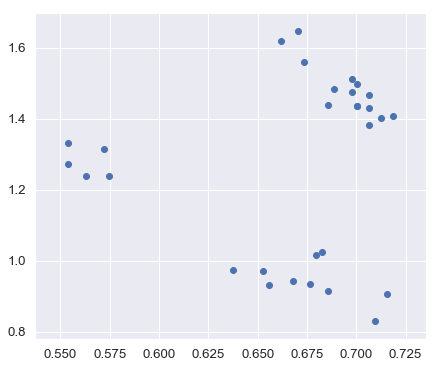

,ExpWelf_accuracy,ExpCost_german_credit_payoffs
0,0.574850,1.239521
1,0.571856,1.314371
2,0.562874,1.239521
3,0.553892,1.332335
4,0.553892,1.272455
5,0.706587,1.383234
6,0.661677,1.619760
7,0.700599,1.437126
8,0.700599,1.437126
9,0.697605,1.476048


In [60]:
x_metric = 'ExpWelf_accuracy'
y_metric = 'ExpCost_german_credit_payoffs'
df[(~df[x_metric].isna()) & (~df[y_metric].isna())][[x_metric, y_metric]]
fig, ax = plt.subplots(1, 1, figsize=(7, 6))
ax.scatter(df[x_metric], df[y_metric])
plt.show()
df[(~df[x_metric].isna()) & (~df[y_metric].isna())][[x_metric, y_metric]]

In [703]:
cols = ['algorithm', 'DemParWelf_accuracy', 'ExpWelf_accuracy', 'ExpCost_german_credit_payoffs']
df[df['ExpCost_german_credit_payoffs'] > 0][cols]

,algorithm,DemParWelf_accuracy,ExpWelf_accuracy,ExpCost_german_credit_payoffs
0,Random,0.970296,0.562874,0.437126
1,Random,1.000139,0.607784,0.392216
2,Random,0.882770,0.631737,0.368263
3,Random,1.024845,0.640719,0.359281
4,Random,0.705748,0.526946,0.473054
5,SVM,0.800325,0.688623,0.311377
6,SVM,0.938235,0.676647,0.323353
7,SVM,0.905352,0.670659,0.329341
8,SVM,0.916219,0.718563,0.281437
9,SVM,0.806109,0.646707,0.353293


In [621]:
for col in df.columns:
    print(col)

algorithm
params
run-id
0-FNR
0-FNR_over_1-1-FNR
0-FNR_over_1-FNR
0-FPR
0-FPR_over_1-1-FPR
0-FPR_over_1-FPR
0-TNR
0-TNR_over_1-1-TNR
0-TNR_over_1-TNR
0-TPR
0-TPR_over_1-1-TPR
0-TPR_over_1-TPR
0-accuracy
0-accuracy_over_1-1-accuracy
0-accuracy_over_1-accuracy
0-calibration+
0-calibration+_over_1-1-calibration+
0-calibration+_over_1-calibration+
0-calibration-
0-calibration-_over_1-1-calibration-
0-calibration-_over_1-calibration-
1-FNR
1-FNR_over_1-1-FNR
1-FPR
1-FPR_over_1-1-FPR
1-TNR
1-TNR_over_1-1-TNR
1-TPR
1-TPR_over_1-1-TPR
1-accuracy
1-accuracy_over_1-1-accuracy
1-calibration+
1-calibration+_over_1-1-calibration+
1-calibration-
1-calibration-_over_1-1-calibration-
BCR
CV
DIavgall
DIbinary
DemParWelf
DemParWelf-tpr-tpr
DemParWelfTPRTPR
DemParWelf_TPRTPR
DemParWelf_accuracy_accuracy
DemParWelf_pos_rate_pos_rate
DemParWelf_tpr_accuracy
DemParWelf_tpr_tpr
ExpCost_accuracy
ExpCost_german_credit_payoffs
ExpWelf_accuracy
ExpWelf_pos_rate
MCC
Name not implemented
TNR
TPR
accuracy
age-FNR
a

```
  g   h
c   d
  e    f
a   b
```

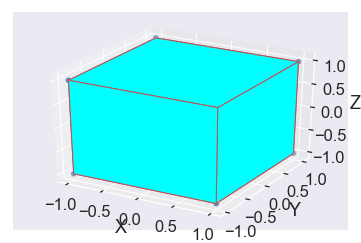

In [487]:
points = np.array([[-1, -1, -1],
                  [1, -1, -1 ],
                  [1, 1, -1],
                  [-1, 1, -1],
                  [-1, -1, 1],
                  [1, -1, 1 ],
                  [1, 1, 1],
                  [-1, 1, 1]])

w = 2
l = 2
h = 2

a = [-1, -1, -1]
b = [a[0]+w, a[1]  , a[2]  ]
c = [a[0]  , a[1]  , a[2]+h]
d = [a[0]+w, a[1]  , a[2]+h]
e = [a[0]  , a[1]+l, a[2]  ]
f = [a[0]+w, a[1]+l, a[2]  ]
g = [a[0]  , a[1]+l, a[2]+h]
h = [a[0]+w, a[1]+l, a[2]+h]
points = np.array([a,
                  b,
                  f,
                  e,
                  c,
                  d,
                  h,
                  g])

Z = points
# Z = 10.0*Z
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
# r = [-1,1]
# X, Y = np.meshgrid(r, r)
ax.scatter3D(Z[:, 0], Z[:, 1], Z[:, 2])
verts = [[Z[0],Z[1],Z[2],Z[3]],
 [Z[4],Z[5],Z[6],Z[7]],
 [Z[0],Z[1],Z[5],Z[4]],
 [Z[2],Z[3],Z[7],Z[6]],
 [Z[1],Z[2],Z[6],Z[5]],
 [Z[4],Z[7],Z[3],Z[0]]]
ax.add_collection3d(Poly3DCollection(verts, facecolors='cyan', linewidths=1, edgecolors='r', alpha=.20))
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.show()